# SQD for metaphosphate

## Setup

In [56]:
import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})
import numpy as np
import pickle

import qiskit
from qiskit import qasm3
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [57]:
ibm_computer: str = "ibm_fez"
qubits = (
    list(range(65, 70)) + [77, 78] + list(range(83, 92)) + [96, 97, 98] + list(range(100, 112))
    + [116, 117, 118] + list(range(120, 130))
)
nshots: int = 100_000

nqubits = len(qubits)
nqubits

44

In [58]:
# Skip this cell if not running on hardware.
service = qiskit_ibm_runtime.QiskitRuntimeService(name="NERSC-US")
computer = service.backend(ibm_computer)
sampler = Sampler(computer)

## Read in the Hamiltonian and ansatz circuit

In [59]:
adapt_iterations = 20

In [60]:
hamiltonian = f"metaphosphate-circuits_hamiltonian_{adapt_iterations:02d}_adaptiterations.pkl"
hamiltonian

'metaphosphate-circuits_hamiltonian_20_adaptiterations.pkl'

In [61]:
circuit_dir =  "circuits"
circuit_fname = f"metaphosphate-circuit_{adapt_iterations:02d}_adaptiterations.qasm"
circuit_path = f"{circuit_dir}/{circuit_fname}"
circuit_path

'circuits/metaphosphate-circuit_20_adaptiterations.qasm'

In [62]:
circuit = qasm3.load(circuit_path)
circuit.draw(fold=-1, idle_wires=False)

░                                                                                                               ░                                                                                                                                                                                                                                                                                                                         ░                                                                                                                                                                                                                          ░                                                                                                                                                                                                                                                                                                              ░  ░                                                                                                                                                                                                            ░ ┌───┐┌───┐               ┌───┐┌──────────┐                                                                                                                                                                                                                                                                                                 ░                                                                                                                                                                                                                                                                                                                                                                                                              ░  ░                                                                                                                                                                                                                                                                                              ░                                                        ░                                                                                                                                                 ░                                                                                                                                                                                   ░                                                                                                                                                                                                                                                                                                                                                  ░                                                                                              ░                                                                                                                                                                                                                                                                                                                                                                                                                                                     ░                                                               ░                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             ░                        

In [63]:
len(circuit.qubits)

44

In [64]:
# from qiskit.converters import circuit_to_dag, dag_to_circuit


# dag = circuit_to_dag(circuit)
# print(list(dag.idle_wires()))
# dag.remove_qubits(*list(dag.idle_wires()))
# circuit = dag_to_circuit(dag)

In [65]:
base = circuit.copy()
base = qiskit.transpiler.passes.RemoveBarriers()(base)
base.count_ops()

OrderedDict([('cx', 950),
             ('rz', 559),
             ('sx', 248),
             ('s', 186),
             ('h', 137),
             ('x', 49)])

## Prepare to run on hardware

In [66]:
to_run = base.copy()
to_run.measure_all()
to_run = [to_run]

In [67]:
to_run = qiskit.transpile(
    to_run,
    optimization_level=3,
    backend=computer,
    initial_layout=qubits,
    seed_transpiler=123
)

In [68]:
for c in to_run:
    print(c.count_ops())

OrderedDict([('sx', 2881), ('rz', 1946), ('cz', 1611), ('x', 105), ('measure', 44), ('barrier', 1)])


In [69]:
to_run[0].depth()

1408

In [70]:
ops = list(to_run[0].count_ops().keys())
num = list(to_run[0].count_ops().values())

In [71]:
sum([number for op, number in to_run[0].count_ops().items() if op != "cz"])

4977

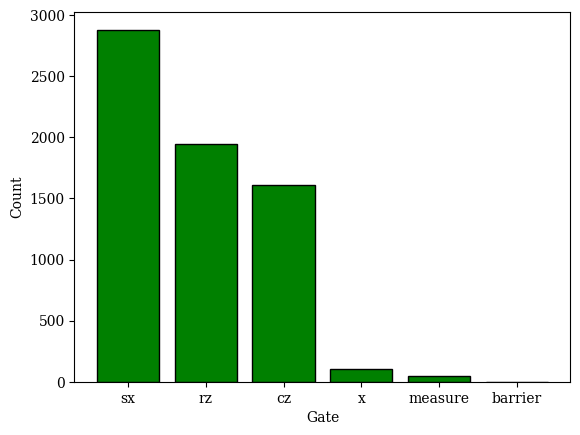

In [72]:
plt.bar(ops, num, color="green", edgecolor="black")
plt.xlabel("Gate")
plt.ylabel("Count");

In [73]:
# to_run[0].draw(fold=-1, idle_wires=False)

## Run on exact simulator

In [74]:
# simulator = AerSimulator(method="matrix_product_state")
# result = simulator.run(to_run, shots=10)
# counts = result.result().get_counts()
# counts

In [75]:
# hartree_fock_bitstring = list(counts.keys())[0]
# hartree_fock_bitstring

## Run on noisy simulator

In [76]:
# sim = AerSimulator.from_backend(computer, method="matrix_product_state")

In [77]:
# result = sim.run(to_run, shots=nshots)
# counts = result.result().get_counts()

In [78]:
# qiskit.visualization.plot_histogram(
#     counts,
#     target_string=hartree_fock_bitstring,
#     sort="hamming",
#     number_to_keep=10,
#     figsize=(7, 8),
#     title=sim.name,
# )

## Run on hardware

In [79]:
job = sampler.run(to_run, shots=nshots)
# job = service.job("d5n5uarh36vs73bitksg")

In [80]:
all_counts_hardware = []

In [81]:
res = job.result()

In [82]:
for r in res:
    all_counts_hardware.append(r.data.meas.get_counts())

In [83]:
len(all_counts_hardware[0])

100000

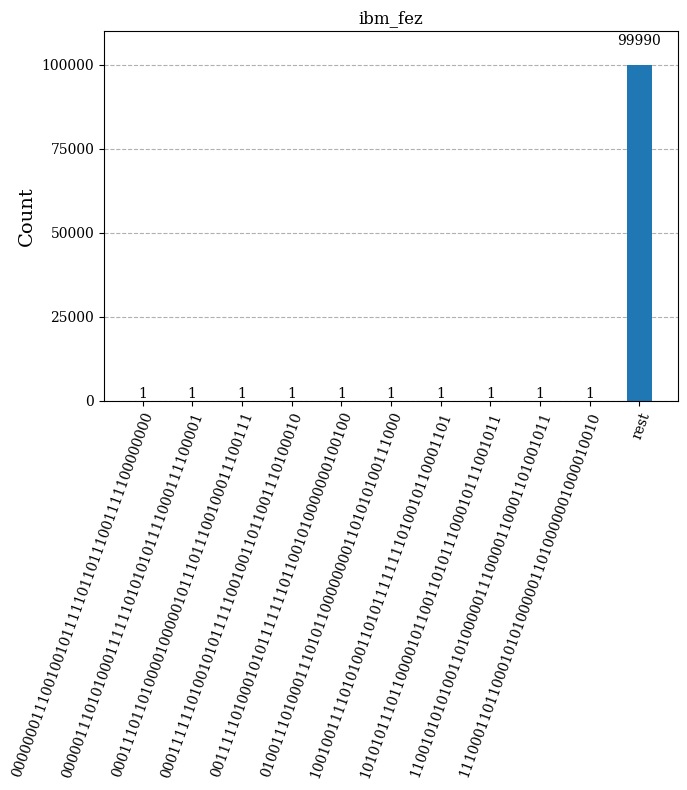

In [84]:
import qiskit.visualization


qiskit.visualization.plot_histogram(
    all_counts_hardware[0],
    # target_string=hartree_fock_bitstring,
    # sort="hamming",
    number_to_keep=10,
    figsize=(7, 8),
    title=computer.name,
)

## Save data

In [85]:
import datetime


time_key = datetime.datetime.now().strftime("%Y_%m_%d_%H-%M-%S")
fname = circuit_fname + f"_counts_{computer.name}_nshots_{nshots}_{time_key}"
fname

'metaphosphate-circuit_20_adaptiterations.qasm_counts_ibm_fez_nshots_100000_2026_02_18_21-10-05'

In [86]:
pickle.dump(all_counts_hardware[0], open(fname, "wb"))

## Run SQD

In [ ]:
import pyscf.tools
from pyscf import ao2mo

import collections
from functools import partial
import os
import pickle

from qiskit.primitives import BitArray
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch

In [49]:
mode_order = pickle.load(
    open(f"{circuit_dir}/metaphosphate_mode_order_{adapt_iterations:02d}_adaptiterations.pkl", "rb")
)
qubit_order = pickle.load(
    open(f"{circuit_dir}/metaphosphate_qubit_order_{adapt_iterations:02d}_adaptiterations.pkl", "rb")
)

In [50]:
hamiltonian_dir = "hamiltonians"

In [51]:
ls hamiltonians/

metaphosphate-circuits_hamiltonian_10_adaptioniterations.pkl
metaphosphate-circuits_hamiltonian_20_adaptiterations.pkl
metaphosphate.npz
owp_reactant.npz


In [55]:
np.load("hamiltonians/metaphosphate.npz")

NpzFile 'hamiltonians/metaphosphate.npz' with keys: NORB, NELEC, ECORE, H1, H2

In [53]:
hamiltonian = pickle.load(
    open(
        f"{hamiltonian_dir}/metaphosphate-circuits_hamiltonian_{adapt_iterations:02d}_adaptioniterations.pkl",
        "rb"
    )
)

In [54]:
type(hamiltonian)

openfermion.ops.operators.qubit_operator.QubitOperator

In [ ]:
fcidump = pyscf.tools.fcidump.read(f"{hamiltonian_dir}/{adapt_iterations:02d}.fcidump")

In [ ]:
n_orbitals = fcidump.get("NORB")
num_electrons = fcidump.get("NELEC")
ecore = fcidump.get("ECORE")
h1 = fcidump.get("H1")
h2 = fcidump.get("H2")
h2 = ao2mo.restore(1, h2, n_orbitals)

In [ ]:
energy_tol = 1e-8
occupancies_tol = 1e-8
carryover_threshold = 1e-5

In [ ]:
fname = "atp_0_be2_f4_040_adaptiterations.qasm_counts_ibm_boston_nshots_100000_2026_02_03_01-33-50"

In [ ]:
counts = pickle.load(
    open(f"results/{fragment}/{fname}", "rb")
)

In [ ]:
def transform_bitstring(bits):
    """
    Convert a given bitstring from Openfermion convention 
    (alternating alpha/beta, big endian) to Qiskit (all alpha
    then all beta, little endian).
    """

    left = [bits[i] for i in range(len(bits)) if i % 2 == 1]   # beta
    right = [bits[i] for i in range(len(bits)) if i % 2 == 0]  # alpha

    # Reverse each half
    left.reverse()
    right.reverse()

    # Concatenate
    return ''.join(left + right)

In [ ]:
measurement_outcomes = counts
permuted_outcomes = {}
for original_bitstring in measurement_outcomes.keys():
    qubit_permuted_bitstring = "".join([original_bitstring[qubit_order.index(n)] for n in range(nqubits)])
    mode_permuted_bitstring = "".join([qubit_permuted_bitstring[mode_order.index(n)] for n in range(nqubits)])

    final_permuted_bitstring = transform_bitstring(mode_permuted_bitstring)
    permuted_outcomes[final_permuted_bitstring[::]] = measurement_outcomes[original_bitstring]

bit_array = BitArray.from_counts(permuted_outcomes)
counts = bit_array.get_counts()
max_key = max(counts, key=counts.get)
print(f'Most common bitstring: {max_key} with count {counts[max_key]}')
print(f'Total number of bitstrings: {len(counts)}')
print(f"Total number of samples:", sum(counts.values()))

In [ ]:
sci_solver = partial(solve_sci_batch, spin_sq=0, max_cycle=10000)
result_history = []

def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + ecore}")
        print(f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}")


result = diagonalize_fermionic_hamiltonian(
    one_body_tensor=h1,
    two_body_tensor=h2,
    bit_array=bit_array,
    samples_per_batch=500,
    norb=n_orbitals,
    nelec=(num_electrons // 2, num_electrons // 2),
    num_batches=2,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=100,
    sci_solver=sci_solver,
    symmetrize_spin=True,
    carryover_threshold=carryover_threshold,
    callback=callback,
)